# Bidirectional LSTM (Left Wrist)

##### https://www.kaggle.com/malekzadeh/human-activity-recognition-with-mobile-sensing

##### https://github.com/akhuperkar/HAR-Smartphone-Accelerometer/blob/master/HAR%20Using%20Machine%20Learning%20.ipynb

#### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import math

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import seaborn as sns
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('euler_data_left_wrist.csv')
df = df.drop([0])

In [3]:
print(df)

     PacketCounter  SampleTimeFine    Euler_X    Euler_Y     Euler_Z  \
1                1        79897288 -44.006100  39.279148 -159.631714   
2                2        79913955 -42.771473  40.480717 -158.369705   
3                3        79930622 -42.201080  41.910305 -157.384995   
4                4        79947289 -42.532143  43.498165 -156.531906   
5                5        79963956 -43.704803  45.181152 -155.828735   
..             ...             ...        ...        ...         ...   
400            400        86547421 -11.955125  32.864365 -128.397095   
401            401        86564088 -12.330739  32.791779 -128.447784   
402            402        86580755 -12.582192  32.730774 -128.498215   
403            403        86597422 -12.890846  32.547947 -128.550507   
404            404        86614089 -13.413615  32.255054 -128.663208   

    Unnamed: 11  
1                
2                
3                
4                
5                
..          ...  
400      

In [4]:
df2 = pd.read_csv('Euler_data_left_wrist_label.csv')
df2 = df2.drop([0])
print(df2)

     PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1                1        79897288      1         NaN         NaN           
2                2        79913955      1         NaN         NaN           
3                3        79930622      1         NaN         NaN           
4                4        79947289      1         NaN         NaN           
5                5        79963956      1         NaN         NaN           
..             ...             ...    ...         ...         ...        ...
400            400        86547421      3         NaN         NaN           
401            401        86564088      3         NaN         NaN           
402            402        86580755      3         NaN         NaN           
403            403        86597422      3         NaN         NaN           
404            404        86614089      3         NaN         NaN           

[404 rows x 6 columns]


In [5]:
df_train = df
label_train = df2
print("Shape of original data:", df_train.shape)
print("Shape of labels data:", label_train.shape)

Shape of original data: (404, 6)
Shape of labels data: (404, 6)


In [10]:
print(df_train.head())

   PacketCounter  SampleTimeFine    Euler_X    Euler_Y     Euler_Z Unnamed: 11
1              1        79897288 -44.006100  39.279148 -159.631714            
2              2        79913955 -42.771473  40.480717 -158.369705            
3              3        79930622 -42.201080  41.910305 -157.384995            
4              4        79947289 -42.532143  43.498165 -156.531906            
5              5        79963956 -43.704803  45.181152 -155.828735            


In [12]:
def magnitude(activity):
    x2 = activity['Euler_X'] * activity['Euler_X']
    y2 = activity['Euler_Y'] * activity['Euler_Y']
    z2 = activity['Euler_Z'] * activity['Euler_Z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

df_train['m'] = magnitude(df_train)
df_train.head()

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,Unnamed: 11,m
1,1,79897288,-44.006100,39.279148,-159.631714,,170.181293
2,2,79913955,-42.771473,40.480717,-158.369705,,168.964644
3,3,79930622,-42.201080,41.910305,-157.384995,,168.248154
4,4,79947289,-42.532143,43.498165,-156.531906,,167.938415
5,5,79963956,-43.704803,45.181152,-155.828735,,168.029882


In [13]:
print(label_train.head())

   PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1              1        79897288      1         NaN         NaN           
2              2        79913955      1         NaN         NaN           
3              3        79930622      1         NaN         NaN           
4              4        79947289      1         NaN         NaN           
5              5        79963956      1         NaN         NaN           


In [14]:
pd.DataFrame.from_dict(Counter(label_train['Label']), orient="Index", columns=['label']).reset_index()

,index,label
0,1,81
1,2,169
2,3,154


#### Plot Acceleration Data

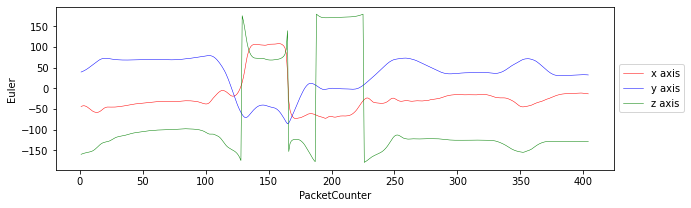

In [15]:
plt.figure(figsize=(10,3))
plt.plot(df_train['PacketCounter'], df_train['Euler_X'], linewidth=0.5, color='r', label='x axis')
plt.plot(df_train['PacketCounter'], df_train['Euler_Y'], linewidth=0.5, color='b', label='y axis')
plt.plot(df_train['PacketCounter'], df_train['Euler_Z'], linewidth=0.5, color='g', label='z axis')
plt.xlabel('PacketCounter')
plt.ylabel('Euler')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

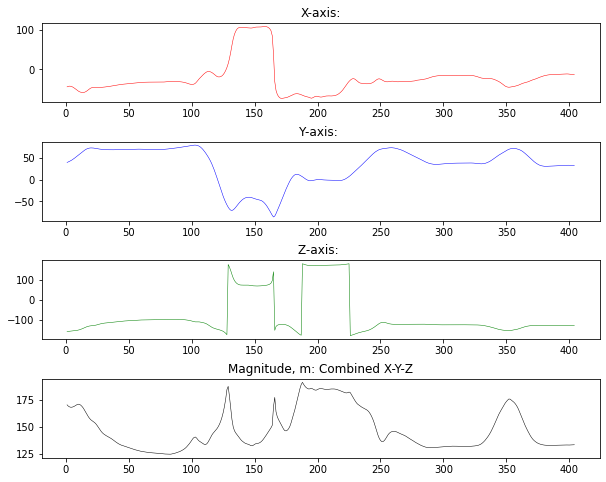

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis:')
ax[0].plot(df_train['PacketCounter'], df_train['Euler_X'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: ')
ax[1].plot(df_train['PacketCounter'], df_train['Euler_Y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: ')
ax[2].plot(df_train['PacketCounter'], df_train['Euler_Z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(df_train['PacketCounter'], df_train['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

In [17]:
# Separating data for each activity
train_df = pd.concat([df_train, label_train['Label']], axis=1).dropna()
columns = ['PacketCounter', 'Euler_X', 'Euler_Y', 'Euler_Z', 'm', 'Label']

wrist_on_elbow = train_df[columns][train_df.Label == 1]
waack = train_df[columns][train_df.Label == 2]
idle = train_df[columns][train_df.Label == 3]

In [18]:
wrist_on_elbow.head()

,PacketCounter,Euler_X,Euler_Y,Euler_Z,m,Label
1,1,-44.006100,39.279148,-159.631714,170.181293,1
2,2,-42.771473,40.480717,-158.369705,168.964644,1
3,3,-42.201080,41.910305,-157.384995,168.248154,1
4,4,-42.532143,43.498165,-156.531906,167.938415,1
5,5,-43.704803,45.181152,-155.828735,168.029882,1


In [19]:
waack.head()

,PacketCounter,Euler_X,Euler_Y,Euler_Z,m,Label
82,82,-30.617115,70.549210,-98.037521,124.603187,2
83,83,-30.334602,70.893494,-97.893745,124.616455,2
84,84,-30.197964,71.241745,-97.872292,124.764934,2
85,85,-30.184610,71.600502,-97.962601,125.037649,2
86,86,-30.168936,71.948547,-98.075966,125.322198,2


In [20]:
idle.head()

,PacketCounter,Euler_X,Euler_Y,Euler_Z,m,Label
251,251,-26.200418,70.368416,-113.722214,136.275155,3
252,252,-28.125341,70.892448,-112.906685,136.252316,3
253,253,-29.763264,71.331276,-113.279068,137.135517,3
254,254,-30.825659,71.767731,-114.622955,138.705625,3
255,255,-31.325451,72.177826,-116.592262,140.658018,3


#### Plot Activity Data

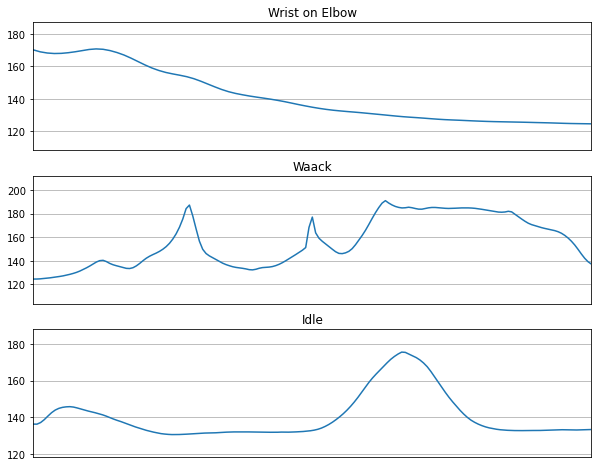

In [21]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['PacketCounter'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([wrist_on_elbow, waack, idle],
              ['Wrist on Elbow', 'Waack', 'Idle'])

#### Split training data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label_train, test_size = 0.2, random_state = 0)

In [23]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (323, 8)
y_train shape: (323, 6)


In [24]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (81, 8)
y_test shape: (81, 6)


In [25]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = label_train['Label'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 300 #400 #200 #300
STEP = 150  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Euler_X', 'Euler_Y', 'Euler_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Euler_X', 'Euler_Y', 'Euler_Z']], 
    TIME_STEPS, 
    STEP
)

In [26]:
print(X_train.shape, y_train.shape)

(254, 150, 3) (254, 1)


In [27]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [28]:
print(X_train.shape, y_train.shape)

(254, 150, 3) (254, 3)


#### Train the model

In [29]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 228 samples, validate on 26 samples
Epoch 1/20
228/228 [==============================] - 4s 17ms/sample - loss: 1.0270 - acc: 0.4868 - val_loss: 1.7765 - val_acc: 0.0000e+00
Epoch 2/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.4192 - acc: 0.8596 - val_loss: 1.9706 - val_acc: 0.0000e+00
Epoch 3/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.2576 - acc: 0.9035 - val_loss: 1.9313 - val_acc: 0.0000e+00
Epoch 4/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.1940 - acc: 0.9079 - val_loss: 1.8943 - val_acc: 0.0000e+00
Epoch 5/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.1349 - acc: 0.9342 - val_loss: 1.8537 - val_acc: 0.0000e+00
Epoch 6/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.1160 - acc: 0.9430 - val_loss: 1.9099 - val_acc: 0.0000e+00
Epoch 7/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.0832 - acc: 0.9825 - val_loss: 1.9435 - val_acc:

#### Evaluation

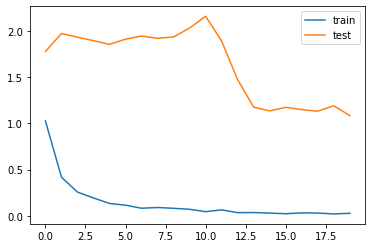

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

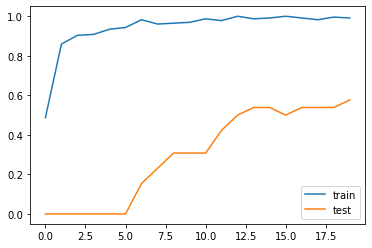

In [32]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [33]:
model.evaluate(X_test, y_test)

254/254 [==============================] - 0s 781us/sample - loss: 0.1249 - acc: 0.9528


[0.12493295861567613, 0.9527559]

In [34]:
model.evaluate(X_train, y_train)

254/254 [==============================] - 0s 793us/sample - loss: 0.1249 - acc: 0.9528


[0.12493295861567613, 0.9527559]

#### Confusion Matrix

In [35]:
y_pred = model.predict(X_test)

In [36]:
column_names = 'Wrist_on_Elbow', 'Waack', 'Idle'

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(column_names)
  ax.set_yticklabels(column_names)
  b, t = plt.ylim() # discover the values for bottom and top
  #b += 0.5 # Add 0.5 to the bottom
  #t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

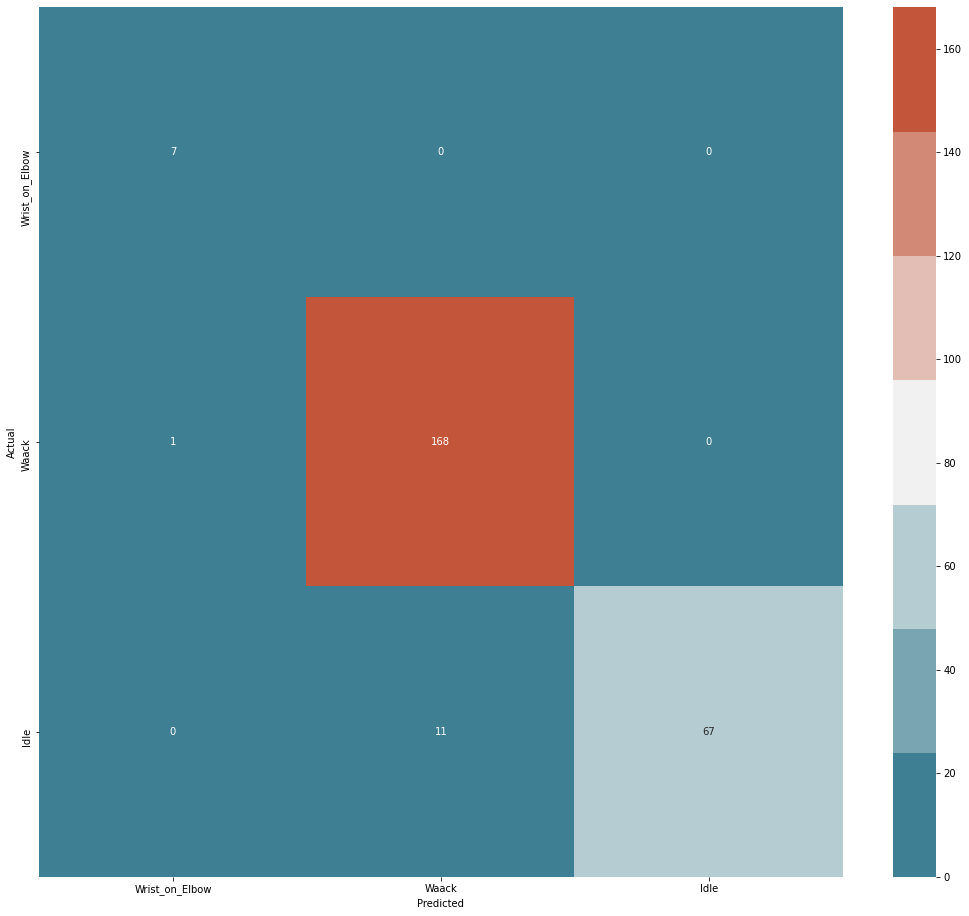

In [37]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)